In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re,glob,os
from collections import defaultdict
import dgutils
import json

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import dframe_tools as dtools
import plot_tools as ptools
import gen_resubmit as gensub

# Comment out for description of below modules
# dtools.help()
# ptools.help()
# gensub.help()

'''
Assign path of OUTPUT files and generate database
Options:
skip = int or float [int: number of line to skip, float: proportion to skip]
noenergy = 0 if you have energy estimator, 1 if you don't. 0: pick 9, 10th column 1: pick 0, 1st column
replace = 1 if you want to replace nan to zero. Be cautious to use it
'''

### If you import data from csv, put 1 here
is_csv = 1


#=========================================================================
if is_csv == 1:

    dbase = pd.read_csv('../data/SFphase_data.csv')
    dbase['filedic'] = dbase['filedic'].apply(lambda x: json.loads(x.replace("'", '"')))

else:
### from raw data
    path = '/home/sang/UVM/He4Graphene/OUTPUT'
    dbase = dtools.df_pimc(path, skip = 0, noenergy = 1, replace = 1)

dfdict = ptools.datadic(dbase)

dict_keys(['0.07,-101.0', '0.07,-103.0', '0.07,-99.0', '0.14,-101.0', '0.09,-101.0', '0.09,-105.0', '0.09,-91.0', '0.09,-103.0', '0.09,-96.0', '0.09,-93.0', '0.1,-101.0', '0.1,-88.0', '0.1,-91.0', '0.1,-98.0', '0.1,-93.0', '0.1,-100.0', '0.03,-101.0', '0.03,-103.0', '0.12,-101.0', '0.12,-88.0', '0.12,-91.0', '0.12,-95.0', '0.12,-96.0', '0.12,-98.0', '0.12,-94.0', '0.12,-100.0', '0.06,-101.0', '0.06,-103.0', '0.06,-99.0', '0.16,-91.0', '0.16,-95.0', '0.16,-87.0', '0.16,-93.0', '0.16,-85.0', '0.08,-101.0', '0.08,-103.0', '0.08,-96.0', '0.08,-99.0', '0.08,-106.0', '0.13,-101.0', '0.22,-81.0', '0.22,-86.0', '0.22,-84.0', '0.22,-82.0', '0.22,-83.0', '0.24,-81.0', '0.24,-76.0', '0.05,-101.0', '0.05,-103.0', '0.05,-99.0', '0.18,-87.0', '0.18,-90.0', '0.18,-92.0', '0.18,-85.0', '0.18,-83.0', '0.04,-101.0', '0.04,-103.0', '0.04,-99.0', '0.2,-88.0', '0.2,-81.0', '0.2,-90.0', '0.2,-86.0', '0.2,-83.0', '0.28,-76.0', '0.15,-93.0'])


In [2]:
### plot style
plot_style = {'notebook':'../include/notebook.mplstyle','sans':'../include/sans_NC.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['sans'])
figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# setup a possible custom font path
from matplotlib import font_manager
def what_font_path (filename):
    for p in font_manager.findSystemFonts(fontpaths=None, fontext="ttf"):
        if p.find(filename) != -1:
            return p

font_path,bold_font_path = '.','.'
if 'LOCAL_FONT_PATH' in os.environ:
    font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Light-08.ttf'
    bold_font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Bold-02.ttf'
else:
    # local path (custom)
    font_path = what_font_path('HelveticaNeue-Light-08')
    bold_font_path = what_font_path('HelveticaNeue-Bold-02')

In [3]:
# sorting for key
def keysorting(k):
    t = k.split(',')
    n = float(t[0])*100000 + float(t[1])
    return n

keylst = []
# Listing keys to ban
banlst = []
# banlst = ['0.03,-103.0','0.04,-103.0','0.05,-103.0', '0.06,-103.0', '0.07,-103.0']

for keys in dfdict.keys():
    if keys not in banlst:
        keylst.append(keys)
keylst = sorted(keylst, key = lambda k: keysorting(k))

# Check sorted list of keys
print(keylst)
print('number of category:', len(keylst))

# nparallel check
'''return number of copies with same configurations in the subset dataframes
    if the total # of data is n times total # of (T, totN) combination.
    return None if it's something else'''

for keys in keylst:
    print(ptools.nparallel( dfdict[keys] ) , end='  ')

['0.03,-103.0', '0.03,-101.0', '0.04,-103.0', '0.04,-101.0', '0.04,-99.0', '0.05,-103.0', '0.05,-101.0', '0.05,-99.0', '0.06,-103.0', '0.06,-101.0', '0.06,-99.0', '0.07,-103.0', '0.07,-101.0', '0.07,-99.0', '0.08,-106.0', '0.08,-103.0', '0.08,-101.0', '0.08,-99.0', '0.08,-96.0', '0.09,-105.0', '0.09,-103.0', '0.09,-101.0', '0.09,-96.0', '0.09,-93.0', '0.09,-91.0', '0.1,-101.0', '0.1,-100.0', '0.1,-98.0', '0.1,-93.0', '0.1,-91.0', '0.1,-88.0', '0.12,-101.0', '0.12,-100.0', '0.12,-98.0', '0.12,-96.0', '0.12,-95.0', '0.12,-94.0', '0.12,-91.0', '0.12,-88.0', '0.13,-101.0', '0.14,-101.0', '0.15,-93.0', '0.16,-95.0', '0.16,-93.0', '0.16,-91.0', '0.16,-87.0', '0.16,-85.0', '0.18,-92.0', '0.18,-90.0', '0.18,-87.0', '0.18,-85.0', '0.18,-83.0', '0.2,-90.0', '0.2,-88.0', '0.2,-86.0', '0.2,-83.0', '0.2,-81.0', '0.22,-86.0', '0.22,-84.0', '0.22,-83.0', '0.22,-82.0', '0.22,-81.0', '0.24,-81.0', '0.24,-76.0', '0.28,-76.0']
number of category: 65
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

In [4]:
### Export data
# dbase.to_csv('../data/SFphase_data.csv',index=False)

In [5]:
# Initialize outputs
case_out = {}
case_nmean = {}
case_nerr = {}
case_alist = {}
case_aerrlist = {}

# calculate extrapolated data without plotting them
for k in keylst:
    case_out[k] = ptools.esti_array_multi(dfdict[k])
    case_nmean[k], case_nerr[k] = ptools.non_plot_frac(case_out[k])
    case_alist[k], case_aerrlist[k]  = ptools.non_plot_superfrac(case_out[k])

In [6]:
## reload module
# import importlib
# importlib.reload(ptools)

In [7]:
def name_change(key):
    case_name = key.split(',')
    return str(round(float(case_name[0])*100))+str(int(case_name[1][:-2]))

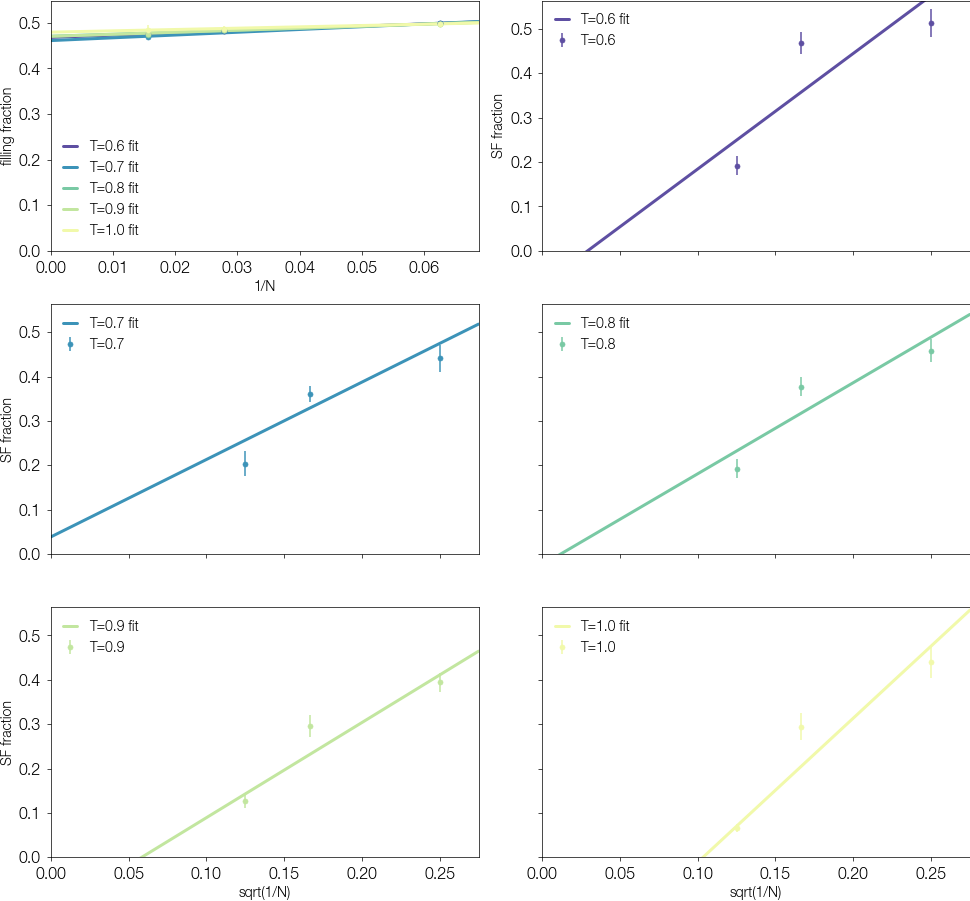

In [8]:
# If you want to plot data, use below
plt.style.reload_library()
dgutils.fonts.set_custom_font(font_path)
case_key = '0.12,-88.0'
_target = dfdict[case_key]
plot_target = _target[_target['T']>0.5]
case_name = name_change(case_key)
case_out[case_key] = ptools.esti_array_multi(plot_target)
nplot = ptools.plot_only(case_out[case_key])
# nplot.savefig('../figures/'+case_name+'.pdf')

In [9]:
# use following functions to SF vs temperature plot of set of keys
def features_T(row):
    
    area = np.sqrt(3)/4*6*1.42
    mass = 10*6.7

    T_lists = [case_out[k]['Tset'] for k in row]
    f_lists = [np.asarray(case_nmean[k])[:,0] for k in row]
    ferr_lists = [np.asarray(case_nerr[k])[:,0] for k in row]
    as_lists = [np.asarray(case_alist[k])[:,0] for k in row]
    as_err_lists = [np.asarray(case_aerrlist[k])[:,0] for k in row]
    rhos_lists = [np.asarray(case_nmean[k])[:,0]*np.asarray(case_alist[k])[:,0]*mass/area for k in row]
    rhos_err_lists = [np.asarray(case_nmean[k])[:,0]*np.asarray(case_aerrlist[k])[:,0]*mass/area for k in row]
    
    return T_lists, f_lists, ferr_lists, as_lists, as_err_lists, rhos_lists, rhos_err_lists

def final_plot(rows):
    linex = np.linspace(0,1.5,10)
    colmax = max([len(row) for row in rows])
    fig, axs = plt.subplots(colmax,len(rows),sharex=True, sharey=True, figsize=[2*len(rows),(1.8)*colmax])
#     plt.setp(axs, xlim=(0,1.5), ylim=(0.2,0.8))

    for j,row in enumerate(rows):
        T_lists, f_lists, ferr_lists, as_lists, as_err_lists, rhos_lists, rhos_err_lists = features_T(row)
        
        for i in range(len(row)):
            ax1 = axs[i,j]
            ax2 = ax1.twinx()
#             ax1.errorbar(T_lists[i],rhos_lists[i], yerr = rhos_err_lists[i], 
#                          color = 'brown', label = row[i]+'vs1/sqrt(N)', elinewidth = 5, ecolor = 'grey')
            ax1.errorbar(T_lists[i],as_lists[i], yerr = as_err_lists[i], 
                         color = 'brown', label = row[i]+'vs1/sqrt(N)', elinewidth = 5, ecolor = 'grey')
            ax1.set_ylim(0,1)
            ax1.legend()
#             axs[i,j].plot(linex,7.6/2.2*linex, label = 'KT static theory')
            ax2.errorbar(T_lists[i],f_lists[i], yerr = ferr_lists[i], fmt = '-',
                         color = 'green', elinewidth = 5, ecolor = 'orange')
            ax2.set_ylim(0.2,0.8)
            ax2.tick_params(axis='y', colors='green')
            if row != rows[-1]:
                ax2.set_yticks(np.arange(0.2,0.8,0.1))
                ax2.set_yticklabels(['' for r in np.arange(0.2,0.8,0.1)])
            
#     fig.text(0.5, 0.0, r'T (K)', ha='center', fontsize=12)
#     fig.text(0.0, 0.5, r'SF density$\times 10^{9} \,$ ($\text{g cm}^{-2}$)', 
#              va='center', rotation='vertical', fontsize=12)
#     fig.text(1.0, 0.5, 'filling', va='center', rotation=-90, fontsize=12)
    fig.tight_layout()

# define keys_row1, keys_row2,keys_row3,keys_row4,
#final_plot((keys_row1,keys_row2,keys_row3,keys_row4))

In [10]:
# Find critical temperature
def features_T_each(k):
    
    area = np.sqrt(3)/4*6*1.42
    mass = 10*6.7

    T_lists = case_out[k]['Tset']
    f_lists = np.asarray(case_nmean[k])[:,0]
    ferr_lists = np.asarray(case_nerr[k])[:,0]
    as_lists = np.asarray(case_alist[k])[:,0]
    as_err_lists = np.asarray(case_aerrlist[k])[:,0]
    rhos_lists = np.asarray(case_nmean[k])[:,0]*np.asarray(case_alist[k])[:,0]*mass/area
    rhos_err_lists = np.asarray(case_nmean[k])[:,0]*np.asarray(case_aerrlist[k])[:,0]*mass/area
    
    return T_lists, f_lists, ferr_lists, as_lists, as_err_lists, rhos_lists, rhos_err_lists

# These are other functions to find Tc, but they are deprecated
def find_Tc(new_x, data):
    Ts = []
    Rs = data[0][::-1]
    triger = -1
    stopper = 0
    for i, v in enumerate(tuple(Rs)):
        if v > 0.1:
            triger = i
            break
    while triger != -1 and stopper == 0:
        checker = 0
        if triger+1 == len(Rs):
            stopper = 1
            break
        for i, v in enumerate(tuple(Rs[triger+1:])):
            if v < 0.1:
                triger += i+1
                break
            else:
                checker += 1
        if checker >= len(Rs)-1-triger:
            stopper = 1
            break
        
                
                
    for i, v in enumerate(tuple(Rs[triger:])):
        if v > 0.1:
            Ts.append(new_x[-1*(i+triger)])
            break
    for i, v in enumerate(tuple(Rs[triger:])):
        if v > 0.2:
            Ts.append(new_x[-1*(i+triger)])
            break
            
    if len(Ts) < 2 :
        return 0  
    else:
        return Ts[0]

def find_Tc_old(new_x, data):
    Ts = []
    Rs = data[0][::-1]
    triger = -1
    stopper = 0
    for i, v in enumerate(tuple(Rs)):
        if v > 0.2:
            Ts.append(new_x[-1*i])
            triger = i
            break
    for i, v in enumerate(tuple(Rs)):
        if v > 1.0:
            Ts.append(new_x[-1*i])
            break
    for i, v in enumerate(tuple(Rs)):
        if v > 1.5:
            Ts.append(new_x[-1*i])
            break
            
    if len(Ts) < 3 :
        return 0
    else:
        return sum(Ts[:-1]) / len(Ts[:-1])
    
def find_root(new_x, Rset):
    Ts = []
    Rs = Rset[::-1]
    triger = -1
    stopper = 0
    for i, v in enumerate(tuple(Rs)):
        if v > 0.01:
            triger = i
            break
    while triger != -1 and stopper == 0:
        checker = 0
        if triger+1 == len(Rs):
            stopper = 1
            break
        for i, v in enumerate(tuple(Rs[triger+1:])):
            if v < 0.01:
                triger += i+1
                break
            else:
                checker += 1
        if checker >= len(Rs)-1-triger:
            stopper = 1
            break
        
                
                
    for i, v in enumerate(tuple(Rs[triger:])):
        if v > 0.01:
            Ts.append(new_x[-1*(i+triger)])
            break
    for i, v in enumerate(tuple(Rs[triger:])):
        if v > 0.1:
            Ts.append(new_x[-1*(i+triger)])
            break
            
    if len(Ts) < 2 :
        return 0  
    else:
        return Ts[0]

In [11]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import statistics

featuredata = {}

for k in keylst:
    T_lists, f_lists, ferr_lists, as_lists, as_err_lists, rhos_lists, rhos_err_lists = features_T_each(k)
    new_x = np.linspace(T_lists[0],T_lists[-1],50)
#     f1 = interp1d(T_lists, f_lists)
#     f2 = interp1d(T_lists, rhos_lists)
#     f2 = interp1d(T_lists, as_lists)
    weight = [1/x for x in T_lists]
    f2 = interp1d(T_lists, as_lists)
#     root1 = find_root(new_x, f2(new_x))
    f3 = UnivariateSpline(T_lists, as_lists, w=weight)
    f3.set_smoothing_factor(1.5)
    root2 = f3.roots()
    dev = np.sum(np.sqrt((f2(T_lists) - f3(T_lists))**2/4))
    
    dev *= (sum(T_lists[-2:])-sum(T_lists[:2]))/(sum(as_lists[-2:])-sum(as_lists[:2]))
    dev = np.sqrt(dev**2)*2
    
    featuredata[k] = [f3(new_x), T_lists, f_lists, ferr_lists, 
                      f_lists*as_lists, f_lists*as_err_lists, 
                      rhos_lists, rhos_err_lists, f2(new_x), as_lists, dev, root2]

In [12]:
# Finds critical temperature and how much smoothing and actual are different
def find_Tc_new(data):
    Ts = []
    Rs = data[0]
    stdev = data[-2]
    root2 = data[-1]
    # when smooth plot is always above 0 and no root
    if len(root2) == 0:
        if Rs[-1] > 0:
            return 1.0, Rs[-1]
        else:
            return 0, 0
    # roots more than 1, but too low value for lowest temperature
    elif len(root2) > 1:
        if Rs[0] < 0.09:
            return 0, 0
        else:
#             return root2[0], np.sqrt((root2[0]-stdev)**2)
            return root2[0], stdev
    # root exist, but too low value for lowest temperature
    else:
        if Rs[0] < 0.09:
            return 0, 0
        else:
#             return root2[0], np.sqrt((root2[0]-stdev)**2)
            return root2[0], stdev

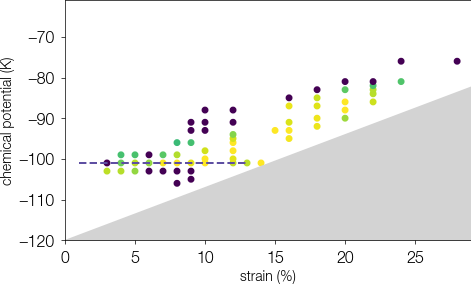

In [13]:
# figure 1: mu-strain w/ Tc phase diagram
mu_s_Tc = []
mu_s_Tc_dev = []
new_x = np.linspace(0.6,1.0,50)

for k in keylst:
#     Tc = find_Tc(new_x, featuredata[k])
    Tc, Tc_dev = find_Tc_new(featuredata[k])
    mu_s_Tc.append(Tc)
    mu_s_Tc_dev.append(Tc_dev)
    

plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    fig1 = plt.figure('fig1') # figsize = [6,4]?
    dgutils.fonts.set_custom_font(font_path)

    ph_x = [float(k.split(',')[0])*100 for k in keylst] # strain
    ph_y = [float(k.split(',')[1]) for k in keylst] # mu

    plt.scatter(ph_x, ph_y, c = np.array(mu_s_Tc), s = 6) # s=20?
    plt.fill_between([0,30], -120 + 1.30*np.array([0,30]), [-120,-120], color = 'lightgray')
    plt.xlim(0,29)
    plt.ylim(-120,-61)
    plt.xlabel('strain (%)') # fontsize = 16?
    plt.ylabel('chemical potential (K)')
    # plt.text(20, -110, 'Vacuum', fontsize = 24)
    plt.hlines(-101.0, 1, 13, ls = '--', lw = 1.0, label = 'next figure')
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
    plt.tight_layout()
    # plt.legend()
    plt.show()

    # Save?
#     fig1.savefig('../figures/Tcs_original.pdf')

In [ ]:
# Export dot data?
# np.savetxt("../data/sfdots_x.csv", ph_x, delimiter =", ", fmt='%.12f')
# np.savetxt("../data/sfdots_y.csv", ph_y, delimiter =", ", fmt='%.12f')
# np.savetxt("../data/sfdots_Tc.csv", mu_s_Tc, delimiter =", ", fmt='%.12f')

In [ ]:
# figure x: T-rhos w/ mu=-101 slice in diagram
# hkeys = []
# for k in keylst:
#     if k[-6:] == '-101.0':
#         hkeys.append(k)
# fig2 = plt.figure('fig2' ,figsize = [6,4])
# markers = ['ko-', 'ko-', 'ks-', 'k*-', 'kD-', 'kp-', 'kP-']
# Tcs = []
# strain = []
# for k in hkeys:
#     Tc = find_Tc(new_x, featuredata[k])
#     Tcs.append(Tc)
#     st = k[:4]
#     st = st.replace(',','0')
#     strain.append(st)

# for i, k in enumerate(hkeys):
#     plt.xlim(0.6, 1.0)
#     plt.ylim(0, 4)
#     xs = featuredata[k][1]
#     xs = np.array(xs)+0.005*(i-3.5)
#     ysl = featuredata[k][0]
#     ys = featuredata[k][-2]
#     yerrs = featuredata[k][-1]
# #     plt.bar(featuredata[k][1], featuredata[k][2], alpha = 0.5)
# #     plt.plot(new_x, ysl,'-')
#     plt.errorbar(xs, ys, yerr=yerrs, 
#                  fmt='.', ecolor=plt.get_cmap('tab10')(i), elinewidth=1, capsize=4, alpha = 0.7
#                 )
# #     plt.scatter(xs, ys, marker = 'd', c = colors[i*-1], s = np.array(yerrs)*1000, alpha = 0.5)
#     plt.plot(xs, ys, markers[i], 
#              color = plt.get_cmap('tab10')(i), mfc='none', 
#              linewidth=1.2, markersize=8, label=f'strain {int(float(strain[i])*100)} \%')
# #     plt.vlines(Tcs[i], 0, 4, color = colors[i*-1])
# plt.legend()
# plt.xlabel('Temperature (K)', fontsize=14)
# plt.ylabel(r'SF density$\times 10^{9} \,$ ($\text{g cm}^{-2}$)', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# plt.show()
# fig2.savefig('newfig2.png')

In [14]:
# colormap tools
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb
def mygradient(c1, c2, ratio = 1.0):
    total = 100
    gradnum = int(total*ratio)
    rs = np.linspace(c1[0],c2[0],gradnum)/255
    gs = np.linspace(c1[1],c2[1],gradnum)/255
    bs = np.linspace(c1[2],c2[2],gradnum)/255
    out = [(rs[0],gs[0],bs[0],1) for j in range(total-gradnum)]
    for i in range(gradnum):
        rgb = (rs[i],gs[i],bs[i],1)
        out.append(rgb)
    return out

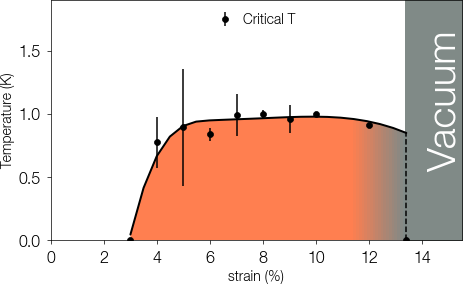

In [15]:
import matplotlib.colors as mcolors

# figure 2: Tc-strain mu = -101 slice in diagram
cut_x = []
cut_y = []
cut_y_dev = []

for x, y, Tc, Tc_dev in zip(ph_x, ph_y, np.array(mu_s_Tc), np.array(mu_s_Tc_dev)):
    if y == -101.0 and int(x) != 14:
        cut_x.append(x)
        cut_y.append(Tc)
        cut_y_dev.append(Tc_dev)
        
f_Tc = UnivariateSpline(cut_x, cut_y)
f_Tc.set_smoothing_factor(0.03)
# new_x = np.linspace(0.03,0.1,20)
# new_x2 = np.arange(3,14.1,0.5)
# new_x3 = np.arange(3,13.4,0.5)
new_x3 = np.linspace(3,13.4,22)

coral = [255,127,80]
coldgrey = [128,138,135]
mycmaplist = mygradient(coral, coldgrey, ratio = 0.2)
mycmap = mcolors.ListedColormap(mycmaplist)

plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    fig3 = plt.figure('fig3',) # figsize = [4,3]
    dgutils.fonts.set_custom_font(font_path)
    
    sfregime = plt.fill_between(new_x3, f_Tc(new_x3), color='none')
    
    verts = np.vstack([p.vertices for p in sfregime.get_paths()])
    gradient = plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap=mycmap, aspect='auto',
                          extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
    gradient.set_clip_path(sfregime.get_paths()[0], transform=plt.gca().transData)
    
    plt.fill_between([13.4,15.5], [2,2], color=mycmaplist[-1])
    pline = plt.plot(new_x3, f_Tc(new_x3), 'k-', linewidth=1.0, )
    plt.errorbar(cut_x[:-1]+[13.4,], cut_y[:-1]+[0,], 
                 ms = 6, mfc = 'k',
                 yerr = cut_y_dev[:-1]+[0,], fmt='.', color = 'k', label = 'Critical T')

    plt.xlabel('strain (%)', ) #fontsize=14
    plt.ylabel('Temperature (K)', ) #fontsize=14
    plt.xlim(0,15.5)
    plt.ylim(0, 1.9)
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
    plt.legend(loc = 'upper center', ) #fontsize = 12
    plt.vlines(13.4, 0, f_Tc(13.4), linestyles ="dashed", colors ="k")
    fig3.text(0.9, 0.42, 'Vacuum', fontsize=20, color='white', rotation = 90)
    plt.tight_layout()
    plt.show()

    # save?
#     fig3.savefig('../figures/Tc_cut.pdf')
    # fig3.savefig('/home/sang/UVM/He4HighT/Allfigures/Tc_cut2.png', dpi=400, pad_inches=0.1,)

# To determine the phase boundary, we use 0.6K data

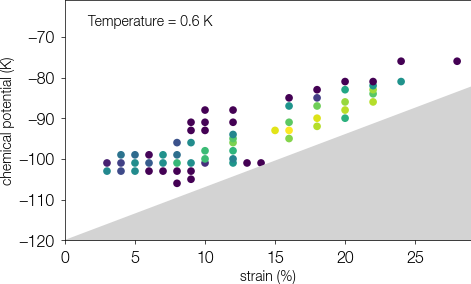

In [16]:
# Generate dot data for later use
# figure 4: mu-strain at T=0.6K w/ rhos phase diagram
mu_s_rhos = []

plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    fig4 = plt.figure('fig4' ,) #figsize = [6,4]
    dgutils.fonts.set_custom_font(font_path)

    ph_x = [float(k.split(',')[0])*100 for k in keylst] # strain
    ph_y = [float(k.split(',')[1]) for k in keylst] # mu

    for k in keylst:
        Ts = featuredata[k][1]
        loc = np.where(np.array(Ts) == 0.6)
        val = float(featuredata[k][6][loc])
        if val < 0:
            val = 0
        mu_s_rhos.append(float(val))

    pts = plt.scatter(ph_x, ph_y, c = np.array(mu_s_rhos), s=8) #s = 20
    plt.fill_between([0,30], -120 + 1.30*np.array([0,30]), [-120,-120], color = 'lightgray')
    plt.xlim(0,29)
    plt.ylim(-120,-61)
    plt.xlabel('strain (%)', ) #fontsize=16
    plt.ylabel('chemical potential (K)', ) #fontsize=16
    # plt.text(20, -110, 'Vacuum', fontsize = 24)
    # plt.hlines(-101.0, 1, 13, ls = '--', lw = 1.0, label = 'next figure')
    cbar = fig3.colorbar(pts)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
    fig4.text(0.2, 0.87, 'Temperature = 0.6 K', color='black') #, fontsize=14
    plt.tight_layout()
    # plt.legend()
    plt.show()

    # save?
#     fig4.savefig('../figures/SFs_at_lowT.pdf')

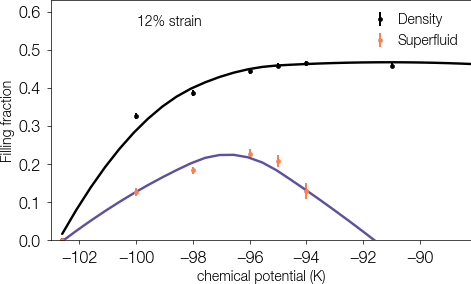

In [17]:
# figure 5: f-mu strain 12% slice in diagram
vkeys = []
for k in keylst:
    if k[:4] == '0.12':
        vkeys.append(k)
vkeys = vkeys[1:]

plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    fig5 = plt.figure('fig5' ,) #figsize = [4,3]
    dgutils.fonts.set_custom_font(font_path)
    
    markers = ['ko-', 'ko-', 'ks-', 'k*-', 'kD-', 'kp-', 'kP-']
    mus = [float(k.split(',')[1]) for k in vkeys]
    mus.insert(0, -102.6)
    fr = [0,]
    frerr = [0,]
    sfr = [0,]
    sfrerr = [0,]
    for k in vkeys:
        Ts = featuredata[k][1]
        loc = np.where(np.array(Ts) == 0.6)
        fr_i = float(featuredata[k][2][loc])
        frerr_i = float(featuredata[k][3][loc])
        sfr_i = float(featuredata[k][4][loc])
        sfrerr_i = float(featuredata[k][5][loc])
        fr.append(fr_i)
        frerr.append(frerr_i)
        sfr.append(sfr_i)
        sfrerr.append(sfrerr_i)

    plt.xlim(-103, -88.2)
    plt.ylim(0, 0.63)

    f_fc = UnivariateSpline(np.array(mus), np.array(fr), k=2)
    f_fc.set_smoothing_factor(0.002)
    f_sfc = UnivariateSpline(np.array(mus), np.array(sfr), k=2)
    f_sfc.set_smoothing_factor(0.002)
    new_mus = np.linspace(mus[0],mus[-1],30)
    plt.plot(new_mus, f_fc(new_mus), 'k-', linewidth=1.2)
    plt.plot(new_mus, f_sfc(new_mus), '-' , linewidth=1.2)

    # plt.scatter(np.array(mus), np.array(fr), s=50, marker='o', color = 'k', facecolors='none', label = 'Density')
    plt.errorbar(np.array(mus), np.array(fr), yerr = np.array(frerr),
                fmt='o', elinewidth=1, label='Density', color='k')
    plt.errorbar(np.array(mus), np.array(sfr), yerr = np.array(sfrerr),
                fmt='o', elinewidth=1, label='Superfluid', color='coral')

    plt.xlabel('chemical potential (K)',) # fontsize=14
    plt.ylabel('Filling fraction',) # fontsize=14
    plt.legend()
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
    # plt.vlines(-91.8, 0, 0.2)
    plt.tight_layout()
    fig5.text(0.3, 0.87, '12% strain', color='black') #  fontsize=12

    plt.show()

    # save?
#     fig5.savefig('../figures/lowT_strain12.pdf')
    # fig5.savefig('/home/sang/UVM/He4HighT/Allfigures/12_vcut2.png',  dpi=400, pad_inches=0.1,)

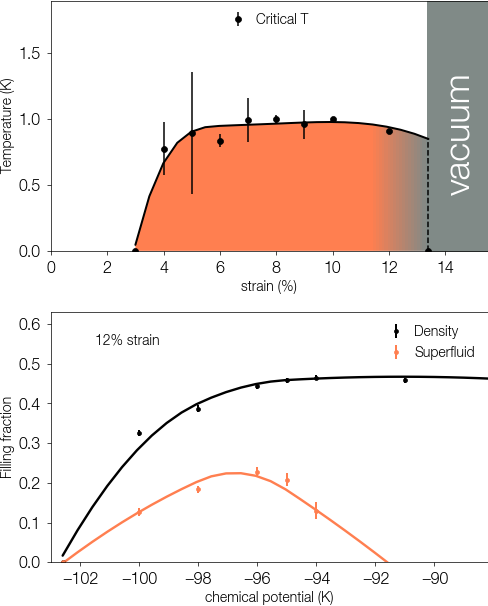

In [21]:
# fig = plt.figure(constrained_layout=True)
# ax_dict = fig.subplot_mosaic(mosaic)
mosaic = """
A
B
"""

plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    fig_stack = plt.figure(constrained_layout=True , figsize = (3.4646, 2.14122*2)) # figsize = [4,3] or 3.4646, 2.14122
    ax_dict = fig_stack.subplot_mosaic(mosaic)
    dgutils.fonts.set_custom_font(font_path)
    
    ax1 = ax_dict["A"]
    
    sfregime = ax1.fill_between(new_x3, f_Tc(new_x3), color='none')
    
    verts = np.vstack([p.vertices for p in sfregime.get_paths()])
    gradient = ax1.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap=mycmap, aspect='auto',
                          extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
    gradient.set_clip_path(sfregime.get_paths()[0], transform=plt.gca().transData)
    
    ax1.fill_between([13.4,15.5], [2,2], color=mycmaplist[-1])
    pline = ax1.plot(new_x3, f_Tc(new_x3), 'k-', linewidth=1.0, )
    ax1.errorbar(cut_x[:-1]+[13.4,], cut_y[:-1]+[0,], 
                 ms = 6, mfc = 'k',
                 yerr = cut_y_dev[:-1]+[0,], fmt='.', color = 'k', label = 'Critical T')

    ax1.set_xlabel('strain (%)', ) #fontsize=14
    ax1.set_ylabel('Temperature (K)', ) #fontsize=14
    ax1.set_xlim(0,15.5)
    ax1.set_ylim(0, 1.9)
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
    ax1.legend(loc = 'upper center', ) #fontsize = 12
    ax1.vlines(13.4, 0, f_Tc(13.4), linestyles ="dashed", colors ="k")
    ax1.text(0.9, 0.25, 'vacuum',transform=ax1.transAxes, fontsize=18, color='white', rotation = 90)
    
    ###########################################
    ax2 = ax_dict["B"]
    
    ax2.set_xlim(-103, -88.2)
    ax2.set_ylim(0, 0.63)
    
    ax2.plot(new_mus, f_fc(new_mus), 'k-', linewidth=1.2)
    ax2.plot(new_mus, f_sfc(new_mus), '-', color = 'coral', linewidth=1.2)

    # plt.scatter(np.array(mus), np.array(fr), s=50, marker='o', color = 'k', facecolors='none', label = 'Density')
    ax2.errorbar(np.array(mus), np.array(fr), yerr = np.array(frerr),
                fmt='o', elinewidth=1, label='Density', color='k')
    ax2.errorbar(np.array(mus), np.array(sfr), yerr = np.array(sfrerr),
                fmt='o', elinewidth=1, label='Superfluid', color='coral')

    ax2.set_xlabel('chemical potential (K)',) # fontsize=14
    ax2.set_ylabel('Filling fraction',) # fontsize=14
    ax2.legend()

    ax2.text(0.1, 0.87, '12% strain',transform=ax2.transAxes, color='black') #  fontsize=12
    
#     plt.tight_layout()
    plt.show()
    
    fig_stack.savefig('../figures/fig4.pdf')

# Finding upper bound
Below codes are hard coded

In [ ]:
# Find boundary SF vanish
guess = -85.7

vkeys = []
for k in keylst:
    if k[:4] == '0.16':
        vkeys.append(k)

fig5 = plt.figure('fig5' ,figsize = [6,4])
markers = ['ko-', 'ko-', 'ks-', 'k*-', 'kD-', 'kp-', 'kP-']
mus = [float(k.split(',')[1]) for k in vkeys]
mus.insert(0, -100)
fr = [0,]
sfr = [0,]
sfrerr = [0,]
for k in vkeys:
    Ts = featuredata[k][1]
    loc = np.where(np.array(Ts) == 0.6)
    fr_i = float(featuredata[k][2][loc])
    sfr_i = float(featuredata[k][4][loc])
    sfrerr_i = float(featuredata[k][5][loc])
    fr.append(fr_i)
    sfr.append(sfr_i)
    sfrerr.append(sfrerr_i)

plt.xlim(-100, -80)
plt.ylim(0, 0.6)
plt.plot(np.array(mus), np.array(fr), 'ko-',
        mfc='none', linewidth=1.2, markersize=8, label='density')
plt.errorbar(np.array(mus), np.array(sfr), yerr = np.array(sfrerr),
            fmt='-', elinewidth=1, capsize=4, label='superfluid')

plt.xlabel('chemical potential (K)', fontsize=16)
plt.ylabel('fraction', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.vlines(guess, 0, 0.2)
plt.tight_layout()
fig5.text(0.13, 0.87, 'at 12\% strain', fontsize=14, color='black')

plt.show()

# save?
# fig5.savefig('newfig5.png')

# Following field is for resubmission codes.
## It read 'log' file for continue simulation and make slurm cmd file

In [ ]:
# Make target dataframe for submission
# Example:
target = dbase[(dbase['mu'] == -101.0)&(dbase['estsize'] < 4000)]
print('target df length is: ',len(target))

In [ ]:
# Current date
date = 'May09'
# Filename, date, suffix
gensub.continue_from(target, 'pimc_cont', date, suffix = 0)

## If you copy, transfer, remove files that you want, use this field

In [ ]:
### pick up files what you need
ct = 0
# subset is dataframe you want
subset = target
for idx, row in subset.iterrows():
#     print(row['filedic'])
    !cp /home/sang/UVM/He4Graphene/OUTPUT/gce-*{row['id']}* /home/sang/UVM/He4Graphene/lessthan4k/OUTPUT/
#     !rm ./tosend/gce-*{row['id']}*
    ct += 1
print('Total number of process:', ct)